In [1]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json, matplotlib, sys, time
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
import seaborn as sns; from sqlalchemy import create_engine
from IPython import display
%matplotlib inline

# When are users most active on the tile... and how experienced are they?

In [2]:
study_tiles = json.loads(open('../study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 9 tiles.


In [3]:
years = [2005+i for i in range(12)]
years

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [4]:
# Create connections for panda queries
pd_engines = []
pd_connections = []
for idx, year in enumerate(years):
    pd_engines.append( create_engine("postgresql://anderstj@127.0.0.1:5432/world-{0}".format(year)) )
    pd_connections.append(pd_engines[idx].connect())

def reset(pd_connections):
    new_cons = []
    for idx, con in enumerate(pd_connections):
        con.close()
        new_cons.append(pd_engines[idx].connect())
    return new_cons

# pd_connections = reset(pd_connections)

In [5]:
def get_all_users_who_edited_tile(tile):
    users_on_tile = []
    for idx, year in enumerate(years):
        print(year, end=" . ")
        query_string = """SELECT distinct(uid) FROM per_tile WHERE quadkey = '{0}'""".format(tile['quad'])
        year_df = pd.read_sql_query(query_string,con=pd_connections[idx])
        users_on_tile = np.append(users_on_tile,year_df.uid.values)
    return np.unique(users_on_tile)

def annual_worker_function(args):
    """
    Input: List of users and a year of choice
    Returns: Dictionary, keyed by UID of all a user's edits for given year
    """
    (user_list, year_idx, q) = args
    dict_to_return = {}

    #Query for 50 users at a time
    for sub_list in [user_list[i:i + 50] for i in range(0, len(user_list), 50)]:
    
        query_string = """SELECT per_tile.quadkey,
                                 per_tile.year,
                                 per_tile.uid,
                                 per_tile.buildings,
                                 per_tile.road_km,
                                 per_tile.amenities,
                                 per_tile.edits,
                                 array_length(per_tile.active_days,1) AS "num_days",
                                 user_stats.uid AS "user_stats_uid",
                                 user_stats.name AS "user_name",
                                 user_stats.year AS "total_year",
                                 user_stats.buildings AS "total_buildings",
                                 user_stats.road_km AS "total_road_km",
                                 user_stats.amenities AS "total_amenities",
                                 user_stats.edits AS "total_edits",
                                 array_length(user_stats.active_days,1) AS "total_active_days"
                          FROM per_tile, user_stats 
                          WHERE per_tile.uid = user_stats.uid AND 
                                per_tile.uid = ANY(ARRAY[%s])"""%(", ".join([str(i) for i in sub_list]))
        df = pd.read_sql_query(query_string, con=pd_connections[year_idx])
        
#         with open('tmp.log','w') as oFile:
#             oFile.write(df.to_csv())

        for uid in df['uid'].unique():
            dict_to_return[uid] = df[:][df.uid == uid]
            q.put(1)
    return dict_to_return

def build_user_distributions(uids):
    """
        Given a list of user ids, spin up 12 processes (1 per year) to get back dictionaries, keyed by UID
            of all a user's tiles for that year; then combine all of the years.
        
        Returns: A dictionary: { UID : DataFrame of all a user's edits (across all years) }
    """
    m = Manager()
    q = m.Queue()
    p = Pool(12)
    args = [ (uids, year_idx, q) for year_idx in range(12)]
    
    max_val = round(len(uids)*len(args)*0.4)

    result = p.map_async(annual_worker_function, args)
    
    while True:
        if result.ready():
            break
        else:
            size = q.qsize()
            sys.stderr.write("\r "+str(size)+ "/ ~ " + str(max_val))
            time.sleep(1)
    
    aggregated = {}
    
    for year_data in result.get():
        for uid, data in year_data.items():
            if uid in aggregated:
                aggregated[uid]['df'] = pd.concat([aggregated[uid]['df'], data], ignore_index=True)
            else:
                #This is the first we see this user
                aggregated[uid] = {'df':data}
    p.close()
    return aggregated

### With each user's dataframe, compute user focus stats

In [6]:
def calculate_user_focus(args):
    """
    
    """
    df, q = args
    agged_quad = df.groupby('quadkey').aggregate({'buildings':sum,
                                                 'road_km'  :sum,
                                                 'edits'    :sum,
                                                 'amenities':sum,
                                                 'num_days' :sum})
    
    agged_quad['percent_user_road_km']   = agged_quad.road_km   / agged_quad.road_km.sum()*100
    agged_quad['percent_user_buildings'] = agged_quad.buildings / agged_quad.buildings.sum()*100
    agged_quad['percent_user_amenities'] = agged_quad.amenities / agged_quad.amenities.sum()*100
    agged_quad['percent_user_edits']     = agged_quad.edits     / agged_quad.edits.sum()*100
    

    annual_stats = pd.DataFrame()
    for year in df.total_year.unique():
        this_year = df[['uid','user_name','year','total_buildings','total_road_km','total_amenities','total_edits','total_active_days']].query('year=={0}'.format(year)).head(1)
        annual_stats = pd.concat( [annual_stats, this_year], ignore_index=True)
    
    if(q):
        q.put(1)
    return (agged_quad, annual_stats)

def process_dictionary_of_users(user_dict):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], q) for uid in sorted_users]
    result = p.map_async(calculate_user_focus, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['tiles'] = res[idx][0]
        user_dict[user]['annual'] = res[idx][1]
        
    p.close()

In [7]:
def pull_out_study_tile(args):
    """
        For each user, pull out just the quadkey we want; but also tally the annual stuff...
    """
    df, quad, q = args
    
    tile_of_interest = pd.DataFrame(df.query("quadkey=='{0}'".format(quad)))

    if(q):
        q.put(1)
    return tile_of_interest

def process_dictionary_of_users_for_study_tile_stats(user_dict, quad):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], quad, q) for uid in sorted_users]
    result = p.map_async(pull_out_study_tile, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['toi'] = res[idx]
        
    p.close()

In [8]:
def build_all_stats_for_tile(current_tile):
    """
    
    """
    current_tile_df = pd.DataFrame()
    for u,data in current_tile['users'].items():
        data['tiles']['uid'] = u
        data['tiles']['total_editing_days_ever'] = data['annual'].total_active_days.sum()
        data['tiles']['total_buildings_ever'] = data['annual'].total_buildings.sum()
        data['tiles']['total_road_km_ever'] = data['annual'].total_road_km.sum()
        data['tiles']['total_amenities_ever'] = data['annual'].total_amenities.sum()
        data['tiles']['total_edits_ever'] = data['annual'].total_edits.sum()
        current_tile_df = pd.concat([current_tile_df, pd.DataFrame(data['tiles'].query("quadkey=='{0}'".format(current_tile['quad'])))],ignore_index=True)

    current_tile_df['percent_tile_road_km']   = current_tile_df.road_km   / current_tile_df.road_km.sum()*100
    current_tile_df['percent_tile_buildings'] = current_tile_df.buildings / current_tile_df.buildings.sum()*100
    current_tile_df['percent_tile_amenities'] = current_tile_df.amenities / current_tile_df.amenities.sum()*100
    current_tile_df['percent_tile_edits']     = current_tile_df.edits     / current_tile_df.edits.sum()*100
    
    return current_tile_df

# Study Tiles: Load data for a specific study tile

In [9]:
for idx, tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London
8 Manhattan, NY


## 1. Get the `user_list`

In [10]:
"""
    First: Set the index for the study tile you want.
"""
study_tile_idx = 4

In [11]:
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

In [12]:
print("Found: {0} users".format(len(study_tiles[study_tile_idx]['user_list'])))

Found: 201 users


## 2. Build the User Distributions
If this doesn't run, run the cell 2 above again)

In [13]:
study_tiles[study_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['user_list'])

 788/ ~ 965

### Check these results

In [14]:
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,031311303031,2007,1611,0,0.00000,1,29,1,1611,Harry Wood,2007,12,188.38,275,7583,97
1,031311303030,2007,1611,0,0.00000,0,1,1,1611,Harry Wood,2007,12,188.38,275,7583,97
2,031311303032,2007,1611,0,4.96562,0,137,2,1611,Harry Wood,2007,12,188.38,275,7583,97
3,031311303122,2007,1611,0,6.17258,0,107,1,1611,Harry Wood,2007,12,188.38,275,7583,97
4,031311303033,2007,1611,2,6.91752,9,299,6,1611,Harry Wood,2007,12,188.38,275,7583,97


## 3. Get tile focus for each user

In [15]:
process_dictionary_of_users(study_tiles[study_tile_idx]['users'])

 201/201

## 3.5 Pull out per-user-study tile stats

In [16]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['users'], study_tiles[study_tile_idx]['quad'])

 200/201

Processed Study tiles now have the following attributes: 

- **name**: Name of Region
- **user_list**: List of UIDs of users who have edited on this tile
- **users**: Dictionary, keyed by UID
  - `uid`:
    - **df**: Full dataframe of all edits on all tiles by this user
    - **tiles**: DataFrame of unique tiles, summed over all years
    - **annual**: DataFrame of Editing Aggregates over all tiles, per year
    - **toi**: DataFrame of just edits to the study tile per user

# Begin Analysis

In [21]:
print("Current Study Tile: {0}".format(study_tiles[study_tile_idx]['name']))
print("\tUsers: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))

Current Study Tile: Monrovia, Liberia
	Users: 201


In [22]:
overtime_df = pd.DataFrame()
for uid, data in study_tiles[study_tile_idx]['users'].items():

    safe_df = pd.DataFrame(data['annual'].sort_values(by='year'))
    safe_df['active_days_to_date'] = safe_df.total_active_days.cumsum()

    new_df = data['toi'].merge(safe_df[['active_days_to_date','year']], on='year')

    overtime_df = pd.concat([overtime_df, new_df],ignore_index=True)

overtime_df.head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,033330222101,2014,1443840,9,0.000000,0,9,1,1443840,dkunce,2014,8300,331.439000,71,9894,78,99
1,033330222101,2016,1443840,2,0.000000,4,7,1,1443840,dkunce,2016,8933,582.833000,224,10256,66,276
2,033330222101,2014,343553,0,0.000000,0,2,1,343553,mathias_on_the_road,2014,390,6704.580000,129,5220,121,522
3,033330222101,2014,104962,339,3.026860,0,363,3,104962,techlady,2014,4576,8395.580000,148,15582,183,1214
4,033330222101,2015,3170819,3,0.628062,6,13,1,3170819,Cazorla,2015,3,0.628062,6,13,1,1


In [23]:
overtime_df.query('active_days_to_date>10').query('year==2010').head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
187,033330222101,2010,28609,0,0.0,0,1,1,28609,bcrosby,2010,9,90.7871,1,3189,7,49


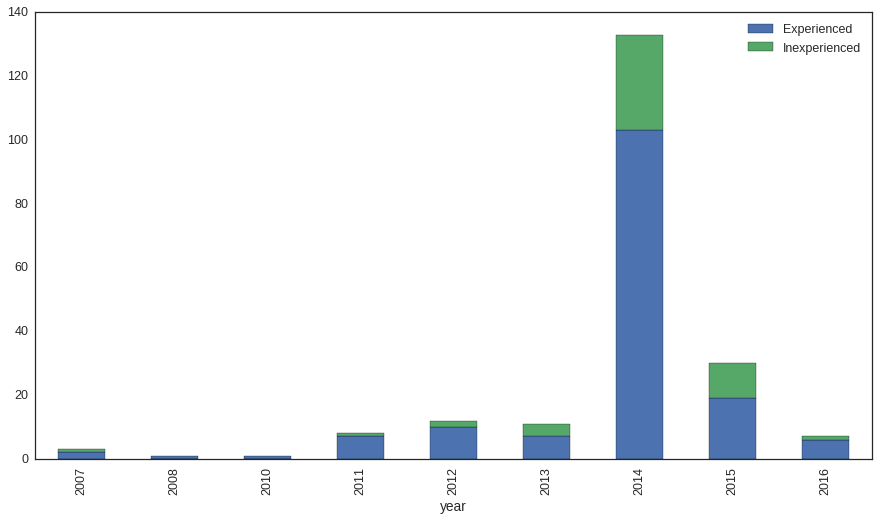

In [24]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

threshold = 7

gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

gt_10.columns = ['Experienced']
lt_10.columns = ['Inexperienced']

gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

<hr>
# Run Tile-by-Tile Comparisons
For each study tile, we have _comparable_ tiles, these are the tiles of most interest, because the difference in patterns between these tiles and our study tiles is what makes the analysis.

## 1. Get a _comparable_ tile

In [25]:
if 'compare_tiles' in study_tiles[study_tile_idx]:
    print("Comparable Tiles for {0}: ".format(study_tiles[study_tile_idx]['name']))
    for idx, compare in enumerate(study_tiles[study_tile_idx]['compare_tiles']):
        print("\t{0}, '{1}'".format(idx, compare['quad']))

Comparable Tiles for Monrovia, Liberia: 
	0, '310101233020'


In [26]:
#Which tile to compare? (from within the comparable study tiles)
compare_tile_idx=0

## 2. Get Users

In [28]:
pd_connections = reset(pd_connections)
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

## 3. Build actual user distribution (may take a few minutes)
If it fails, run the above cell again (probably twice)

In [29]:
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'])

 167/ ~ 226

In [30]:
# Check these results?
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,120201132302,2007,7749,0,0.045943,1,8,1,7749,Matze,2007,0,791.482,18,14391,44
1,120201132213,2007,7749,0,1.031600,2,123,2,7749,Matze,2007,0,791.482,18,14391,44
2,120201303123,2007,7749,0,3.203340,0,109,2,7749,Matze,2007,0,791.482,18,14391,44
3,120201303122,2007,7749,0,6.175670,0,1,1,7749,Matze,2007,0,791.482,18,14391,44
4,120201303033,2007,7749,0,1.652740,0,1,1,7749,Matze,2007,0,791.482,18,14391,44


## 3.5 Pull out per-user-study tile stats

In [31]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'], study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['quad'])

 46/47

## 4. Now process user focus for compare tiles

In [32]:
process_dictionary_of_users(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['annual'].head())

 47/47

,buildings,num_days,road_km,edits,amenities,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
023012311301,0,1,0.00000,1,0,0.000000,0.0,0.0,0.006085
023012311303,0,1,0.00000,4,0,0.000000,0.0,0.0,0.024338
023013200223,0,2,6.71009,71,0,0.636372,0.0,0.0,0.432005
023013202001,0,3,15.09830,57,0,1.431895,0.0,0.0,0.346821
023013202003,0,2,1.65447,5,0,0.156907,0.0,0.0,0.030423


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,7749,Matze,2007,0,791.4820,18,14391,44
1,7749,Matze,2008,4,129.1220,31,1479,34
2,7749,Matze,2009,51,44.4655,87,250,32
3,7749,Matze,2010,87,7.0207,4,130,4
4,7749,Matze,2011,2,30.3767,11,78,6


## 5. Build Compare Tile Full Stats

In [33]:
compare_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])
compare_tile_df.count().head()

buildings    47
num_days     47
road_km      47
edits        47
amenities    47
dtype: int64

# Now compare the tiles

First, basic stats: 

In [37]:
print("Users on Study Tile: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))
print("Users on Compare Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list']), len(compare_tile_df)))

Users on Study Tile: 201
Users on Compare Tile: 47, 47


In [38]:
compare_overtime_df = pd.DataFrame()
for uid, data in study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'].items():

    safe_df = pd.DataFrame(data['annual'].sort_values(by='year'))
    safe_df['active_days_to_date'] = safe_df.total_active_days.cumsum()

    new_df = data['toi'].merge(safe_df[['active_days_to_date','year']], on='year')

    compare_overtime_df = pd.concat([compare_overtime_df, new_df],ignore_index=True)

compare_overtime_df.head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,310101233020,2016,72235,0,0.00000,0,3,1,72235,Basstoelpel,2016,3034,655.5100,136,66630,177,2239
1,310101233020,2015,617220,2,0.00000,0,2,2,617220,raniedwianugrah,2015,40241,3667.2300,697,47568,88,256
2,310101233020,2013,1810695,313,28.75720,3,397,9,1810695,Haliq Abdul walid bm lingkungan 269,2013,411,82.6510,10,547,14,14
3,310101233020,2012,651664,2,0.00000,0,4,2,651664,cedirusyaid,2012,2,0.0000,0,6,2,2
4,310101233020,2016,2956817,10,9.73516,0,33,2,2956817,indra mursyidan ahmad,2016,620,35.1219,0,691,3,4


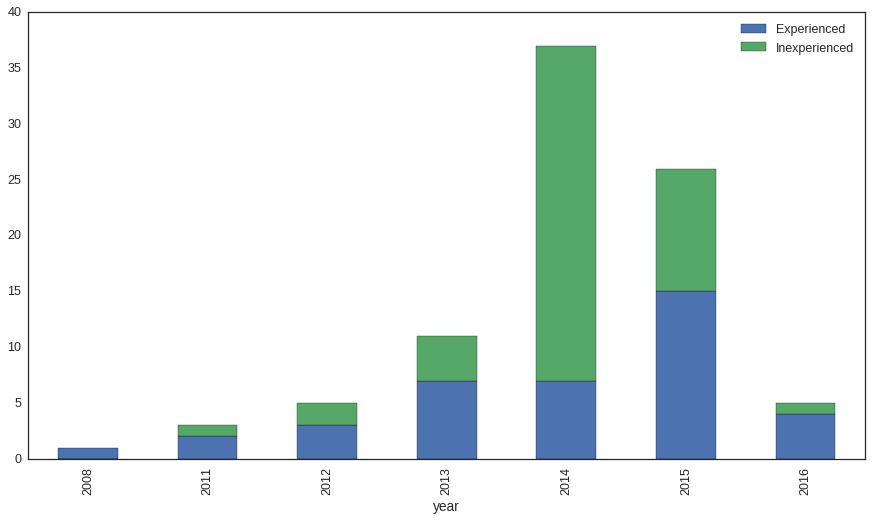

In [39]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

threshold = 7

compare_gt_10 = compare_overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_lt_10 = compare_overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

compare_gt_10.columns = ['Experienced']
compare_lt_10.columns = ['Inexperienced']

compare_gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

## Analysis 

The comparable tile for Monrovia is in [Indonesia](http://www.townsendjennings.com/geojson-polygons?geojson=http://epic-analytics.cs.colorado.edu:9000/jennings/iscram/Monrovia%2c%20Liberia_sim_tiles.geojson#11.69/-5.1467/120.2789)

The distribution of users and experience shows a massive surge of new mappers as opposed to experienced mappers. Perhaps HOT taskers tend to be more experienced?